In [1]:
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import pyedflib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import interpolate
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
directory_path = "/content/eeg-during-mental-arithmetic-task"

def process_edf(file_path):
    f = pyedflib.EdfReader(file_path)

    num_signals = f.signals_in_file

    signal_labels = f.getSignalLabels()

    signals = []
    for i in range(num_signals):
        signals.append(f.readSignal(i))

    f.close()

    return np.array(signals), signal_labels


signals = []
signal_labels = []
file_name = []
for filename in os.listdir(directory_path):
    if filename.endswith(".edf"):  #.edf is the extension for eeg file
        file_name.append(filename)
        file_path = os.path.join(directory_path, filename)
        a ,b = process_edf(file_path)
        signals.append(a)
        signal_labels.append(b)


In [5]:
df = pd.DataFrame({
    'Signal': signals,
    'Name': file_name,
})
df.sort_values(by='Name', ascending=True, inplace=True)
df = df.reset_index().drop(columns=['index'])
df['State'] = df['Name'].str[10:11].astype(int) #Stripping the filename for current state
df['Person'] = df['Name'].str[7:9].astype(int) #Stripping the filename for person number
df = df.drop(columns = ['Name'])
df = pd.get_dummies(df , columns = ['State'] , drop_first = True) #Getting dummy values for

In [6]:
df = pd.DataFrame({
    'Signal': signals,
    'Name': file_name,
})
df.sort_values(by='Name', ascending=True, inplace=True)
df = df.reset_index().drop(columns=['index'])
df['State'] = df['Name'].str[10:11].astype(int) #Stripping the filename for current state
df['Person'] = df['Name'].str[7:9].astype(int) #Stripping the filename for person number
df = df.drop(columns = ['Name'])
df = pd.get_dummies(df , columns = ['State'] , drop_first = True) #Getting dummy values for

In [7]:
print(f"Shape of each each tensor in state 1 {df['Signal'][0].shape}")
print(f"Shape of each each tensor in state 2 {df['Signal'][1].shape}")

Shape of each each tensor in state 1 (21, 91000)
Shape of each each tensor in state 2 (21, 31000)


In [8]:
def pad_or_truncate(signal):
    target_length = 60250
    if signal.shape[1] > target_length:
        return signal[:, :target_length]
    else:
        pad_width = target_length - signal.shape[1]
        return np.pad(signal, ((0, 0), (0, pad_width)), mode='constant')

df['Signal']=df['Signal'].apply(pad_or_truncate)
print(f"Shape of each each tensor in state 1 {df['Signal'][0].shape}")
print(f"Shape of each each tensor in state 2 {df['Signal'][1].shape}")

Shape of each each tensor in state 1 (21, 60250)
Shape of each each tensor in state 2 (21, 60250)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    df['Signal'], df['State_2'], test_size=0.20, random_state=42,stratify = df['State_2'])
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, transform=None):
        self.X_train = X_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]

        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y, dtype=torch.float32)

        return x.to(device), y.to(device)

In [11]:
class Tsception(nn.Module):
    def __init__(self):
        super(Tsception, self).__init__()

        self.temporal_conv1 = nn.Conv2d(1, 16, (1, 8), padding=(0, 4),stride=(1,5))
        self.temporal_conv2 = nn.Conv2d(1, 16, (1, 16), padding=(0, 8),stride=(1,5))
        self.spatial_conv1 = nn.Conv2d(32, 64, (21, 1),stride = (1,5))

        self.fc1 = nn.Linear(154304 , 1000)
        self.fc2 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = torch.relu(self.temporal_conv1(x))

        x2 = torch.relu(self.temporal_conv2(x))


        x = torch.cat((x1, x2), dim=1)

        x = torch.relu(self.spatial_conv1(x))

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))


        x = self.fc2(x)


        x = self.sigmoid(x)

        return x

In [12]:
x = torch.randn(1,1,21,60250)
model = Tsception()
model(x)

tensor([[0.4996]], grad_fn=<SigmoidBackward0>)

In [14]:
dataset = CustomDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [15]:
net = Tsception().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [16]:
num_epochs = 5
loss_e = []

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for x, y in progress_bar:
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))

        del x, y, outputs, loss
        gc.collect()
        torch.cuda.empty_cache()

    avg_epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    loss_e.append(avg_epoch_loss)

Epoch 1/5: 100%|██████████| 4/4 [00:44<00:00, 11.10s/it, loss=0.171]


Epoch [1/5], Loss: 0.1714


Epoch 2/5: 100%|██████████| 4/4 [01:15<00:00, 18.93s/it, loss=0.068]


Epoch [2/5], Loss: 0.0680


Epoch 3/5: 100%|██████████| 4/4 [00:37<00:00,  9.35s/it, loss=7.17e-26]


Epoch [3/5], Loss: 0.0000


Epoch 4/5: 100%|██████████| 4/4 [00:36<00:00,  9.13s/it, loss=2.24e-8]


Epoch [4/5], Loss: 0.0000


Epoch 5/5: 100%|██████████| 4/4 [00:35<00:00,  8.89s/it, loss=4.59e-7]

Epoch [5/5], Loss: 0.0000


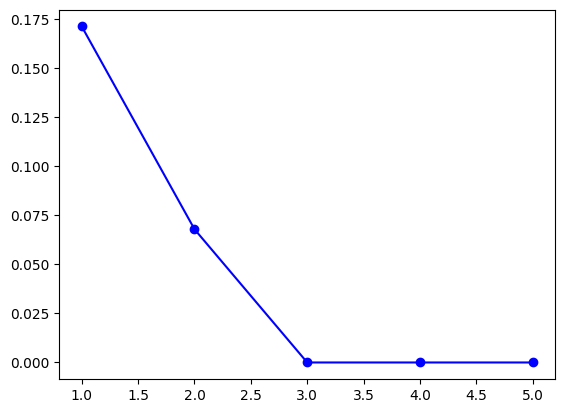

In [17]:
epochs =np.array(range(0, 5))+1
plt.plot(epochs, loss_e, marker='o', linestyle='-', color='b')
plt.show()

In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [19]:
test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
evaluate_model(net,test_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [20]:
evaluate_model(net,dataloader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [21]:
x = df['Signal']
y = df['State_2']
t_dataset = CustomDataset(x, y)
t_loader = DataLoader(t_dataset, batch_size=4, shuffle=False)
evaluate_model(net,t_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
